## Statistical Modeling and Performance Evaluation<a href="#Statistical-Modeling-and-Performance-Evaluation" class="anchor-link"></a>

### Full Model<a href="#Full-Model" class="anchor-link"></a>


### Backwards Feature Selection<a href="#Backwards-Feature-Selection" class="anchor-link"></a>

We now perform backwards feature selection using p-values. It appears
`Statsmodels` does not have any canned code for automatic feature
selection, so we wrote one ourselves.

In [39]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(formula_string_encoded)

# initialize feature-selected fit to full model
linreg_fit = model_full_fitted

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')

while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
    ### print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    

    linreg_fit = smf.ols(formula=patsy_description, data=data_encoded).fit()

###
## this is the clean fit after backwards elimination
model_reduced_fitted = smf.ols(formula = patsy_description, data = data_encoded).fit()
###

#########
print("\n***")
print(model_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_reduced_fitted.f_pvalue:.4f}")
print(f"Regression R-squared: {model_reduced_fitted.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model_reduced_fitted.rsquared_adj:.4f}")


Performing backwards feature selection using p-values:

Removing term "occupation_Farming_fishing" with p-value 0.984

Removing term "occupation_Transport_moving" with p-value 0.3774

Removing term "education_Prof_school" with p-value 0.3591

Removing term "sex_Male" with p-value 0.2642

Removing term "race_White:capital" with p-value 0.1615

Removing term "workclass_Local_gov" with p-value 0.09358

***
                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     642.5
Date:                Thu, 06 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:41:52   Log-Likelihood:            -1.6914e+05
No. Observations:               45222   AIC:                         3.384e+05
Df Residuals:                   45173  

Similar to what we did for the full model, let's define a new data frame
for actual age vs. predicted age and the residuals for the reduced
model.

In [40]:
residuals_reduced = pd.DataFrame({'actual': data_encoded['age'], 
                                  'predicted': model_reduced_fitted.fittedvalues, 
                                  'residual': model_reduced_fitted.resid})
residuals_reduced.head(10)

,actual,predicted,residual
0,39,32.690335,6.309665
1,50,49.461020,0.538980
2,38,41.558042,-3.558042
3,53,37.655981,15.344019
4,28,36.062133,-8.062133
5,37,40.504922,-3.504922
6,49,44.397983,4.602017
7,52,49.654315,2.345685
8,31,35.544969,-4.544969
9,42,44.329267,-2.329267


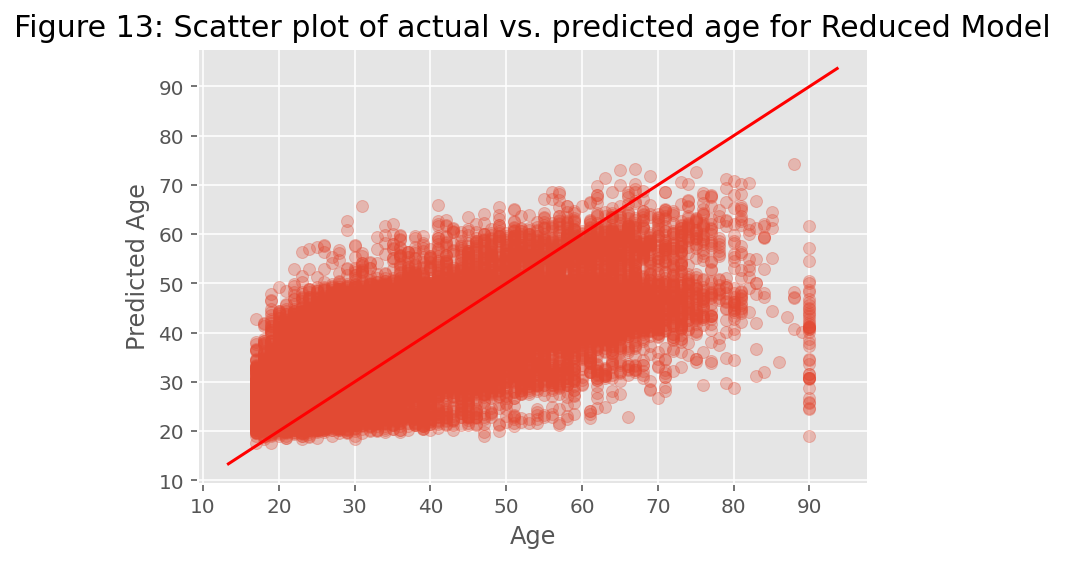

In [41]:
# get a scatter plot
plt.scatter(residuals_reduced['actual'], residuals_reduced['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Age');
plt.ylabel('Predicted Age');
plt.title('Figure 13: Scatter plot of actual vs. predicted age for Reduced Model', fontsize=15);
plt.show(); 

This model returns an Adjusted R-squared of 0.404, meaning the reduced
model still explains about 40% of the variance, but with 6 less
variables. Looking at the p-values, they are all significant at the 5%
level, as expected. From Figure 13, we still have the same issues with
our model. That is, the model overestimates younger ages and
underestimates older ages. We will now perform the diagnostic checks on
this reduced model.

### Reduced Model Diagnostic Checks<a href="#Reduced-Model-Diagnostic-Checks" class="anchor-link"></a>

Let's first get a scatter plot of residuals (as a function of predicted
age).

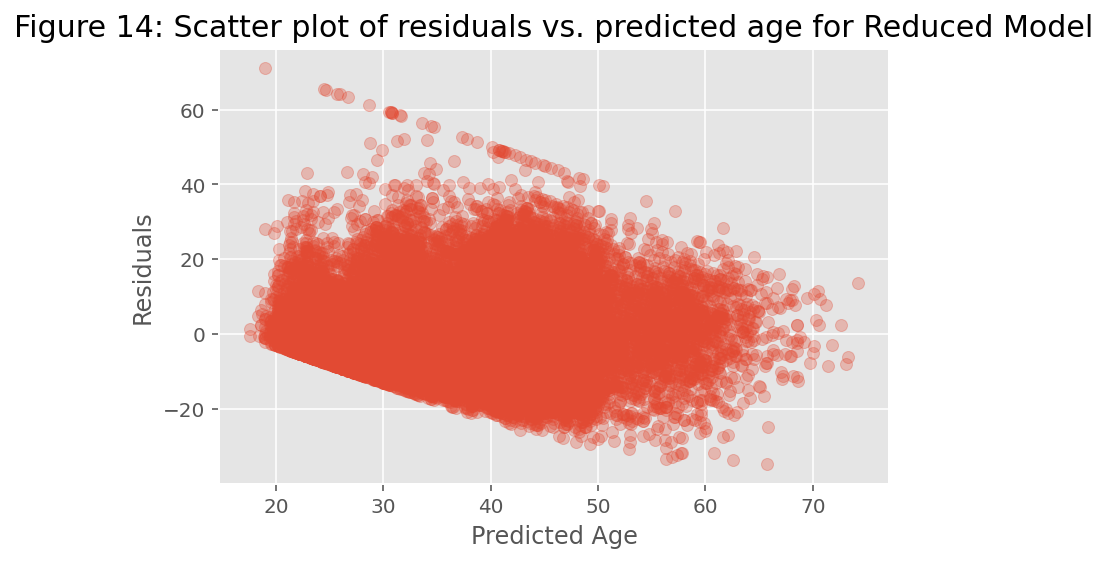

In [42]:
plt.scatter(residuals_reduced['predicted'], residuals_reduced['residual'], alpha=0.3);
plt.xlabel('Predicted Age');
plt.ylabel('Residuals')
plt.title('Figure 14: Scatter plot of residuals vs. predicted age for Reduced Model', fontsize=15)
plt.show();

Figure 14 looks very similar to Figure 10(a), suggesting that the
residuals exhibit the same banding pattern.

Let's now have look at the histogram of the residuals for the reduced
model.

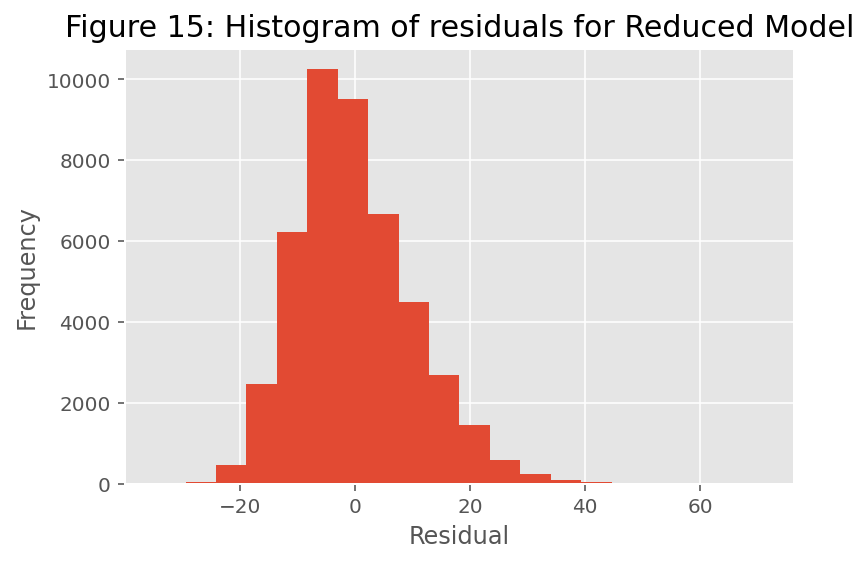

In [43]:
plt.hist(residuals_reduced['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 15: Histogram of residuals for Reduced Model', fontsize = 15)
plt.show();

From Figure 15, there is again a somewhat symmetric histogram around
zero, which suggests that the residuals are somewhat normally
distributed.

## Summary and Conclusions<a href="#Summary-and-Conclusions" class="anchor-link"></a>

Using our independent variables, we were able to get a full model with
an Adjusted R-squared value of about 40%. After backwards variable
selection with a p-value cutoff value of 0.05, we were able to maintain
the same performance but with 6 less variables. Our final model has 49
variables all together with a model p-value of 0.

Diagnostic checks with residual scatter plots indicate that, rather than
being random and centered around 0, the residuals exhibit a banding
pattern, especially when predicted age is below 50. This pattern
indicates that the constant variability assumption of linear regression
is not quite satisfied in this case. On the other hand, residual
histograms suggest that there are no significant violations of the
normality assumption on the residuals.

The final multiple linear regression model has an Adjusted R-squared
value of about 40%, which is pretty low. So, it appears that the
variables we used are not quite adequate for accurately predicting the
age of an individual in the 1994 US Census dataset within a multiple
linear regression framework. A good next step might involve adding some
more interaction terms and maybe some other higher order terms to see if
this would result in some improvement for the Adjusted R-squared value.
Nonetheless, it might be the case that nonlinear models such as a neural
network might be more appropriate for the task at hand rather than a
linear regression model.

Our regression model appears to predict age correctly within \$\\pm40\$
years in general, though this is clearly a huge margin of error for the
model to be useful for any practical purposes. Furthermore, our model
has some rather significant issues. Specifically, our model consistently
overestimates younger ages and underestimates older ages. In particular,
for those younger than the age of 30, the model predicts much older
ages. Also, for those above the age of 80, the model predicts
significantly younger ages.